In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import copy
import json

In [2]:

from chessboard_utils import *




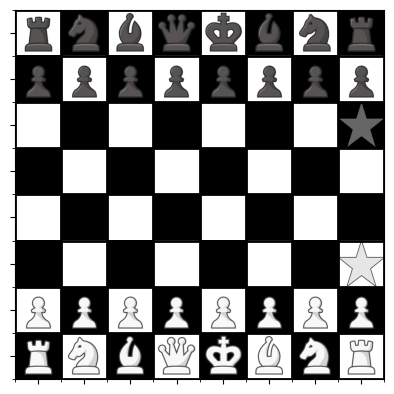

In [3]:
game_state = np.array([
    [-2, -3, -4, -6, -5, -4, -3, -2],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  -7],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  7],
    [ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 2,  3,  4,  6,  5,  4,  3,  2],
])

    
draw_chessboard(game_state, show=True)


In [4]:
from movement_analysis import *

from actualize_game_state import *


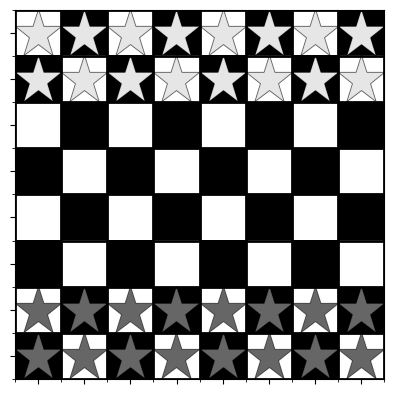


##############################################

Game state 0 (Frame: warped_frame_000100.png):
Invalid move: No changes detected

##############################################

Game state 1 (Frame: warped_frame_000150.png):
Invalid move: No changes detected

##############################################

Game state 2 (Frame: warped_frame_000375.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
valid_pieces ['white_pawn', 'white_rook', 'white_queen']
{'white_pawn': 0.7272727272727273, 'white_rook': 0.18181818181818182, 'white_queen': 0.09090909090909091}
Move: e7 -> e5


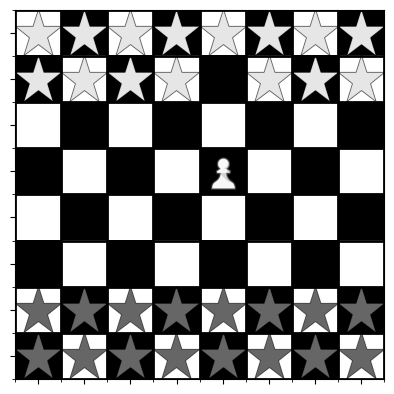


##############################################

Game state 3 (Frame: warped_frame_000400.png):
Invalid move: No changes detected

##############################################

Game state 4 (Frame: warped_frame_000450.png):
Invalid move: No changes detected

##############################################

Game state 5 (Frame: warped_frame_000500.png):
Invalid move: No changes detected

##############################################

Game state 6 (Frame: warped_frame_000550.png):
Invalid move: No changes detected

##############################################

Game state 7 (Frame: warped_frame_000600.png):
Invalid move: No changes detected

##############################################

Game state 8 (Frame: warped_frame_000650.png):
Invalid move: No changes detected

##############################################

Game state 9 (Frame: warped_frame_000800.png):
Invalid move: Invalid number of position changes

##############################################

Game state 10 (Frame: warp

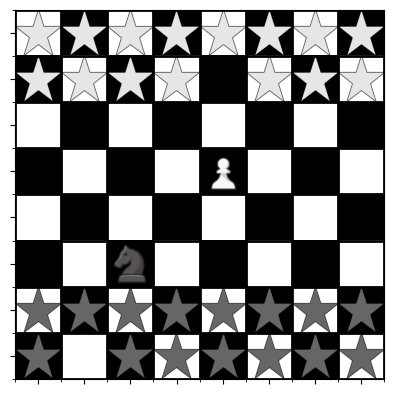


##############################################

Game state 11 (Frame: warped_frame_001100.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
valid_pieces ['white_pawn', 'white_rook', 'white_queen']
{'white_pawn': 0.7272727272727273, 'white_rook': 0.18181818181818182, 'white_queen': 0.09090909090909091}
Move: f7 -> f5


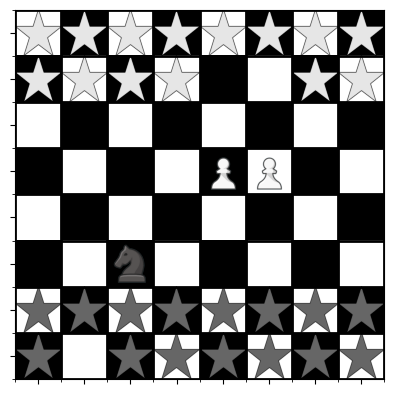


##############################################

Game state 12 (Frame: warped_frame_001150.png):
Invalid move: No changes detected

##############################################

Game state 13 (Frame: warped_frame_001200.png):
Invalid move: No changes detected

##############################################

Game state 14 (Frame: warped_frame_001300.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
king move verified
valid_pieces ['black_pawn', 'black_rook', 'black_queen', 'black_king']
{'black_pawn': 0.6666666666666666, 'black_rook': 0.16666666666666666, 'black_queen': 0.08333333333333333, 'black_king': 0.08333333333333333}
Move: d2 -> d3


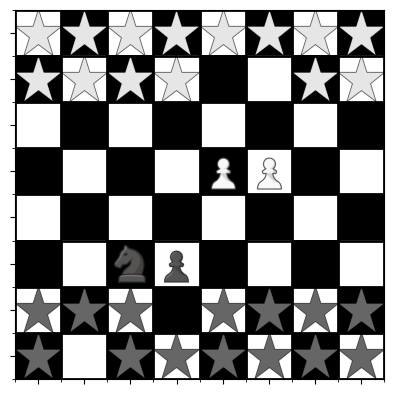


##############################################

Game state 15 (Frame: warped_frame_001350.png):
Invalid move: No changes detected

##############################################

Game state 16 (Frame: warped_frame_001400.png):
Invalid move: No changes detected

##############################################

Game state 17 (Frame: warped_frame_001575.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
knight move verified
valid_pieces ['white_knight']
{'white_knight': 1.0}
Move: g8 -> f6


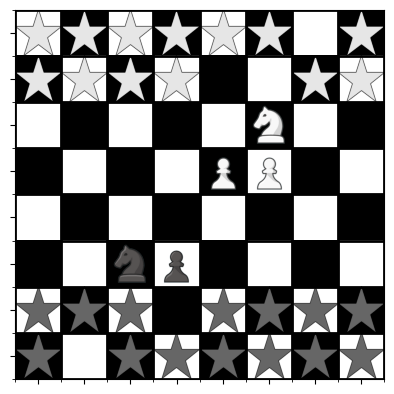


##############################################

Game state 18 (Frame: warped_frame_001600.png):
Invalid move: No changes detected

##############################################

Game state 19 (Frame: warped_frame_001650.png):
Invalid move: No changes detected

##############################################

Game state 20 (Frame: warped_frame_001700.png):
Invalid move: No changes detected

##############################################

Game state 21 (Frame: warped_frame_001750.png):
Invalid move: No changes detected

##############################################

Game state 22 (Frame: warped_frame_001800.png):
Invalid move: No changes detected

##############################################

Game state 23 (Frame: warped_frame_002025.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
bishop move verified
queen move verified
valid_pieces ['black_bishop', 'black_queen']
{'black_bishop': 0.6666666666666666, 'black_queen': 0.3333333333333333}
Move: c1 -> g5


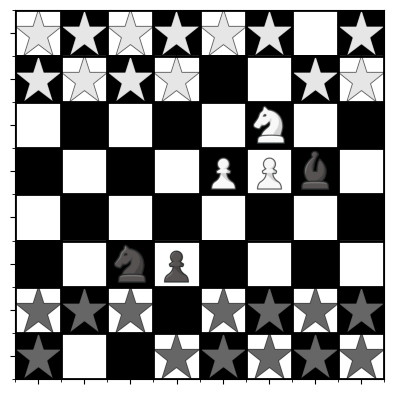


##############################################

Game state 24 (Frame: warped_frame_002050.png):
Invalid move: No changes detected

##############################################

Game state 25 (Frame: warped_frame_002100.png):
Invalid move: No changes detected

##############################################

Game state 26 (Frame: warped_frame_002325.png):
Invalid move: Invalid number of position changes

##############################################

Game state 27 (Frame: warped_frame_002350.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
king move verified
valid_pieces ['white_pawn', 'white_rook', 'white_queen', 'white_king']
{'white_pawn': 0.6666666666666666, 'white_rook': 0.16666666666666666, 'white_queen': 0.08333333333333333, 'white_king': 0.08333333333333333}
Move: c7 -> c6


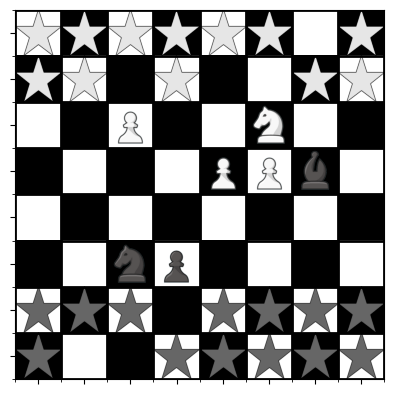


##############################################

Game state 28 (Frame: warped_frame_002400.png):
Invalid move: No changes detected

##############################################

Game state 29 (Frame: warped_frame_002450.png):
Invalid move: No changes detected

##############################################

Game state 30 (Frame: warped_frame_002500.png):
Invalid move: No changes detected

##############################################

Game state 31 (Frame: warped_frame_002700.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
valid_pieces ['black_pawn', 'black_rook', 'black_queen']
{'black_pawn': 0.7272727272727273, 'black_rook': 0.18181818181818182, 'black_queen': 0.09090909090909091}
Move: e2 -> e4


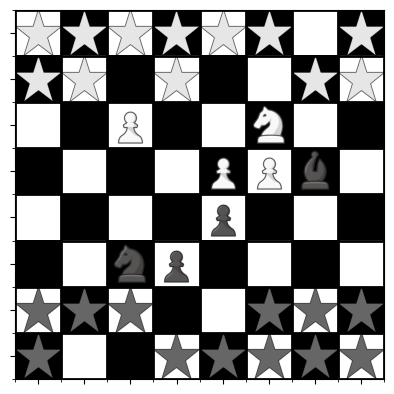


##############################################

Game state 32 (Frame: warped_frame_002750.png):
Invalid move: No changes detected

##############################################

Game state 33 (Frame: warped_frame_002800.png):
Invalid move: No changes detected

##############################################

Game state 34 (Frame: warped_frame_003000.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
king move verified
valid_pieces ['white_pawn', 'white_rook', 'white_queen', 'white_king']
{'white_pawn': 0.6666666666666666, 'white_rook': 0.16666666666666666, 'white_queen': 0.08333333333333333, 'white_king': 0.08333333333333333}
Move: h7 -> h6


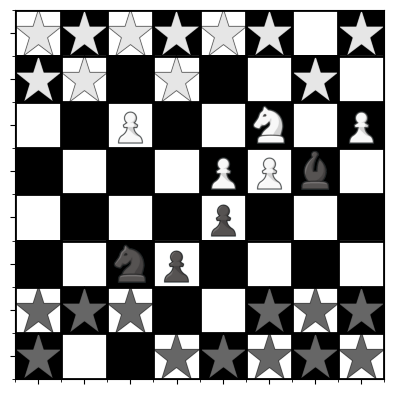


##############################################

Game state 35 (Frame: warped_frame_003050.png):
Invalid move: No changes detected

##############################################

Game state 36 (Frame: warped_frame_003100.png):
Invalid move: No changes detected

##############################################

Game state 37 (Frame: warped_frame_003150.png):
Invalid move: No changes detected

##############################################

Game state 38 (Frame: warped_frame_003375.png):
Invalid move: Invalid number of position changes

##############################################

Game state 39 (Frame: warped_frame_003400.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
bishop move verified
queen move verified
king move verified
valid_pieces ['black_pawn', 'black_bishop', 'black_queen', 'black_king']
{'black_bishop': 0.6666666666666666, 'black_queen': 0.3333333333333333}
Capture: g5 x f6


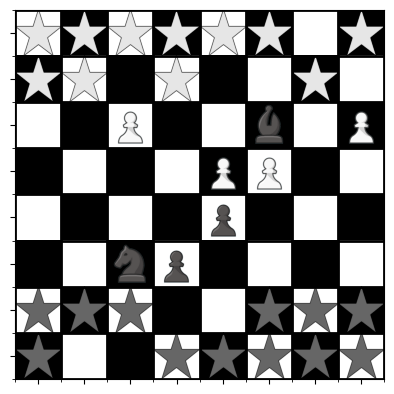


##############################################

Game state 40 (Frame: warped_frame_003450.png):
Invalid move: No changes detected

##############################################

Game state 41 (Frame: warped_frame_003500.png):
Invalid move: No changes detected

##############################################

Game state 42 (Frame: warped_frame_003550.png):
Invalid move: No changes detected

##############################################

Game state 43 (Frame: warped_frame_003775.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
bishop move verified
queen move verified
king move verified
valid_pieces ['white_pawn', 'white_bishop', 'white_queen', 'white_king']
{'white_pawn': 0.6666666666666666, 'white_bishop': 0.16666666666666666, 'white_queen': 0.08333333333333333, 'white_king': 0.08333333333333333}
Capture: g7 x f6


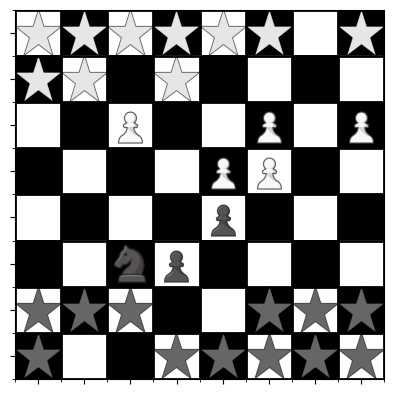


##############################################

Game state 44 (Frame: warped_frame_003800.png):
Invalid move: No changes detected

##############################################

Game state 45 (Frame: warped_frame_003850.png):
Invalid move: No changes detected

##############################################

Game state 46 (Frame: warped_frame_003900.png):
Invalid move: No changes detected

##############################################

Game state 47 (Frame: warped_frame_003950.png):
Invalid move: No changes detected

##############################################

Game state 48 (Frame: warped_frame_004000.png):
Invalid move: No changes detected

##############################################

Game state 49 (Frame: warped_frame_004175.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
valid_pieces ['black_pawn', 'black_rook', 'black_queen']
{'black_pawn': 0.7272727272727273, 'black_rook': 0.18181818181818182, 'black_queen': 0.090909090909

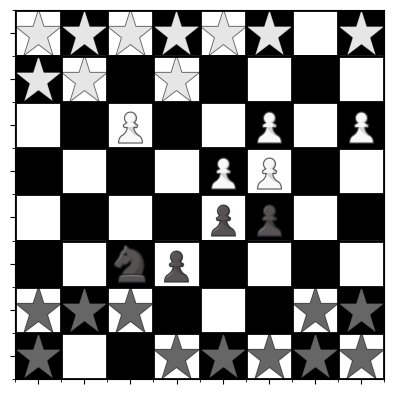


##############################################

Game state 50 (Frame: warped_frame_004200.png):
Invalid move: No changes detected

##############################################

Game state 51 (Frame: warped_frame_004250.png):
Invalid move: No changes detected

##############################################

Game state 52 (Frame: warped_frame_004300.png):
Invalid move: No changes detected

##############################################

Game state 53 (Frame: warped_frame_004525.png):
Invalid move: Invalid number of position changes

##############################################

Game state 54 (Frame: warped_frame_004550.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
bishop move verified
queen move verified
king move verified
valid_pieces ['white_pawn', 'white_bishop', 'white_queen', 'white_king']
{'white_pawn': 0.8888888888888888, 'white_queen': 0.1111111111111111}
Capture: f5 x e4


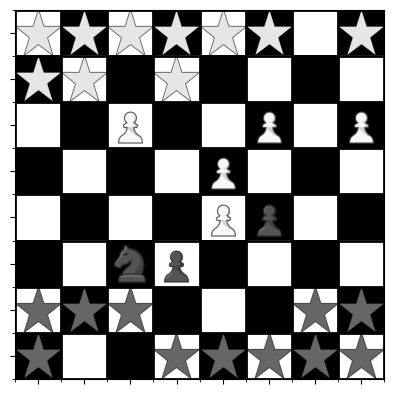


##############################################

Game state 55 (Frame: warped_frame_004750.png):
Invalid move: Invalid number of position changes

##############################################

Game state 56 (Frame: warped_frame_004800.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
bishop move verified
queen move verified
king move verified
valid_pieces ['black_pawn', 'black_bishop', 'black_queen', 'black_king']
{'black_pawn': 0.7999999999999999, 'black_queen': 0.09999999999999999, 'black_king': 0.09999999999999999}
Capture: d3 x e4


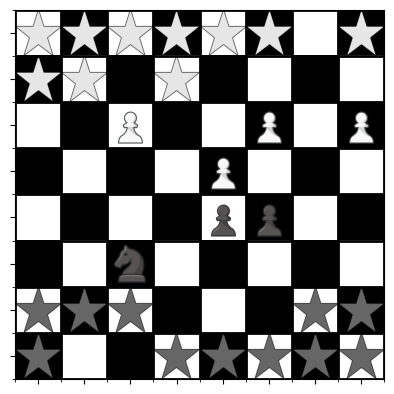


##############################################

Game state 57 (Frame: warped_frame_004850.png):
Invalid move: No changes detected

##############################################

Game state 58 (Frame: warped_frame_005000.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
pawn move verified
rook move verified
queen move verified
king move verified
valid_pieces ['white_pawn', 'white_rook', 'white_queen', 'white_king']
{'white_pawn': 0.6666666666666666, 'white_rook': 0.16666666666666666, 'white_queen': 0.08333333333333333, 'white_king': 0.08333333333333333}
Move: d7 -> d6


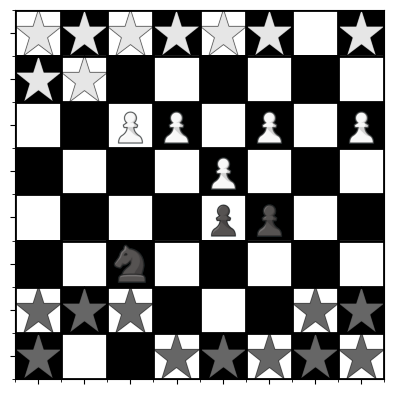


##############################################

Game state 59 (Frame: warped_frame_005050.png):
Invalid move: No changes detected

##############################################

Game state 60 (Frame: warped_frame_005100.png):
Invalid move: No changes detected

##############################################

Game state 61 (Frame: warped_frame_005150.png):
Invalid move: No changes detected

##############################################

Game state 62 (Frame: warped_frame_005200.png):
Invalid move: No changes detected

##############################################

Game state 63 (Frame: warped_frame_005250.png):
Invalid move: No changes detected

##############################################

Game state 64 (Frame: warped_frame_005500.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
bishop move verified
queen move verified
valid_pieces ['black_bishop', 'black_queen']
{'black_bishop': 0.6666666666666666, 'black_queen': 0.3333333333333333}
Move: f1 -> c4


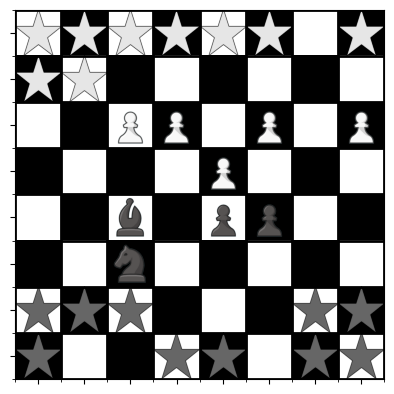


##############################################

Game state 65 (Frame: warped_frame_005550.png):
Invalid move: No changes detected

##############################################

Game state 66 (Frame: warped_frame_005600.png):
Invalid move: No changes detected

##############################################

Game state 67 (Frame: warped_frame_005825.png):
MOVEMENT ANALYSIS
VERIFY MOVEMENT
knight move verified
valid_pieces ['white_knight']
{'white_knight': 1.0}
Move: b8 -> d7


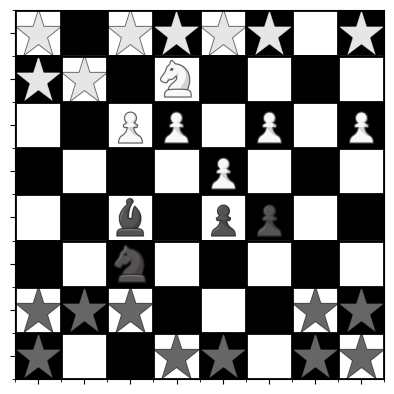


##############################################

Game state 68 (Frame: warped_frame_005850.png):
Invalid move: No changes detected

##############################################

Game state 69 (Frame: warped_frame_005900.png):
Invalid move: No changes detected

##############################################

Game state 70 (Frame: warped_frame_005950.png):
Invalid move: No changes detected

##############################################

Game state 71 (Frame: warped_frame_006000.png):
Invalid move: No changes detected

##############################################

Game state 72 (Frame: warped_frame_006050.png):
Invalid move: No changes detected

##############################################

Game state 73 (Frame: warped_frame_006100.png):
Invalid move: No changes detected

##############################################

Game state 74 (Frame: warped_frame_006150.png):
Invalid move: No changes detected

##############################################

Game state 75 (Frame: warped_frame

In [5]:


# Read the game states from game_state.json
with open('game_state.json', 'r') as f:
    game_data = json.load(f)


last_game_state = game_data['game_states'][0]['gs']

actualized_game_state = {}

draw_chessboard(last_game_state, show=True)


# Display each game state
for i, state in enumerate(game_data['game_states'][1:]):

    print('\n##############################################')
    print(f"\nGame state {i} (Frame: {state['frame']}):")
    # valid_move = True
    
    curr_state = np.array(state['gs'])

    move_analysis = analyze_move(last_game_state, curr_state)

    valid_move = move_analysis['valid']
    
    if move_analysis['valid']:

        last_game_state = curr_state.copy()

        new_game_state, board, piece_certainty = actualize_game_state(actualized_game_state, move_analysis, curr_state)

        # print(new_game_state)

        print(piece_certainty)


        from_pos = move_analysis['from_pos']
        to_pos = move_analysis['to_pos']
        piece = move_analysis['piece']

        valid_pices = move_analysis['valid_pieces']
        
        # Convertir les positions en notation d'échecs
        from_square = f"{chr(97 + from_pos[1])}{8 - from_pos[0]}"
        to_square = f"{chr(97 + to_pos[1])}{8 - to_pos[0]}"
        
        if move_analysis['move_type'] == 'move':

            print(f"Move: {from_square} -> {to_square}")
        
        else:  # capture
            print(f"Capture: {from_square} x {to_square}")

        # print(curr_state)
        draw_chessboard(board, show=True)

        
    else:
        print(f"Invalid move: {move_analysis['message']}")
